<a href="https://colab.research.google.com/github/pratyushethz-star/Pytorch_Tutorials/blob/main/2D_Conduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
#Create a Model Class that inherits nn.Module
class PINN_Model(nn.Module):
  # Input Layer ( 4 Features of Flower ) -->
  #Hidden Layer1 (Number of Neurons) -->
  #H2 (n) -->
  #Output (Three Class of IRIS)
  def __init__(self,in_features=2,h1=20,h2=20,h3=20,out_features=1):
    super().__init__() #Initiate our nn.Module
    self.fc1 = nn.Linear(in_features,h1)
    self.fc2 = nn.Linear(h1,h2)
    self.fc3 = nn.Linear(h2,h3)
    self.out = nn.Linear(h3,out_features)

  def forward(self,x1,x2):
    self.activation = nn.Tanh()
    x = torch.cat([x1,x2],dim=1)
    x = self.activation(self.fc1(x))
    x = self.activation(self.fc2(x))
    x = self.activation(self.fc3(x))
    x = self.out(x)
    return x


In [4]:
import torch

# Assume 50 samples
N = 50
x = torch.rand(N, 1)  # (50, 1)
y = torch.rand(N, 1)  # (50, 1)
t = torch.rand(N, 1)  # (50, 1)

# Concatenate along dim=1 (the feature/column dimension)
input_tensor = torch.cat([x, y, t], dim=1)

print(f"Shape of x, y, t: {x.shape}")
print(f"Shape of concatenated input_tensor: {input_tensor.shape}")

Shape of x, y, t: torch.Size([50, 1])
Shape of concatenated input_tensor: torch.Size([50, 3])


In [5]:
model = PINN_Model()

In [6]:
# Function to compute the PDE residual: u''(x) + pi^2 * u(x) = 0
def pde_residual(model, x1,x2):
    # Make sure x is set to require gradients for derivative calculations.
    x1 = x1.clone().detach().requires_grad_(True)
    x2 = x2.clone().detach().requires_grad_(True)
    u = model(x1,x2)

    # Compute the first derivative, du/dx1.
    u_x1 = torch.autograd.grad(u, x1, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    # Compute the first derivative, du/dx2.
    u_x2 = torch.autograd.grad(u, x2, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Compute the second derivative, d^2u/dx1^2.
    u_xx1 = torch.autograd.grad(u_x1, x1, grad_outputs=torch.ones_like(u_x1), create_graph=True)[0]

    # Compute the second derivative, d^2u/dx^2.
    u_xx2 = torch.autograd.grad(u_x2, x2, grad_outputs=torch.ones_like(u_x2), create_graph=True)[0]

    # Calculate the residual of the PDE.
    residual = u_xx1 + u_xx2 + (torch.pi**2) * u

    return torch.mean(residual ** 2)

In [7]:
# Set up the optimizer and training parameters.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

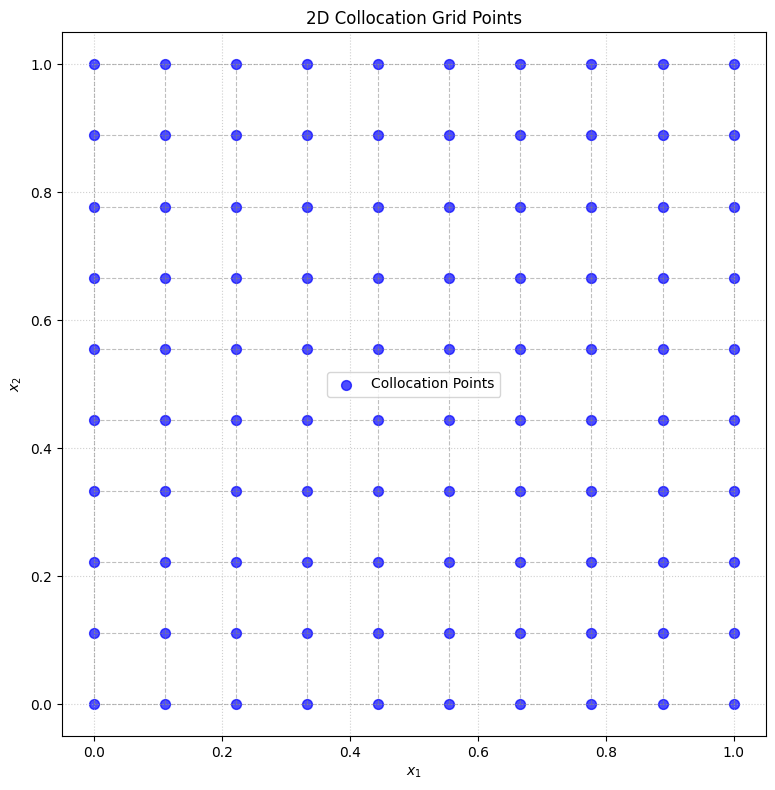

In [8]:
# Create 1D collocation points
x1_collocation_1d = torch.linspace(0, 1, 10) # Using 10 points for clearer visualization
x2_collocation_1d = torch.linspace(0, 1, 10) # Using 10 points for clearer visualization

# Create a 2D meshgrid
X1, X2 = torch.meshgrid(x1_collocation_1d, x2_collocation_1d, indexing='ij')

# Reshape and concatenate for PINN input (N, D) format
x_collocation_input = torch.cat([X1.flatten().unsqueeze(1), X2.flatten().unsqueeze(1)], dim=1)

# Convert to numpy for plotting
x1_plot = X1.cpu().numpy()
x2_plot = X2.cpu().numpy()

# Plotting the grid
plt.figure(figsize=(8, 8))

# Option 1: Plotting individual points (scatter)
plt.scatter(x1_plot, x2_plot, s=50, color='blue', alpha=0.7, label='Collocation Points')

# Option 2: Plotting lines to show the grid structure (optional, but good for visualization)
for i in range(x1_collocation_1d.shape[0]):
    # Horizontal lines
    plt.plot(x1_plot[i, :], x2_plot[i, :], color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    # Vertical lines
    plt.plot(x1_plot[:, i], x2_plot[:, i], color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

plt.title('2D Collocation Grid Points')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.gca().set_aspect('equal', adjustable='box') # Make the grid square
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()

In [14]:
#loss =  u_intial-u_predicted
def initial_loss(model , x1, x2, u0):
  u = model(x1, x2)
  return torch.mean((u - u0) ** 2)

In [23]:
'''
#Neuman Boundary Condition: No Heat Flux Across Boundary
def boundary_loss(model , x_boundary , y_boundary):
  u = model(x_boundary , y_boundary)
  u_n = torch.autograd.grad(u, x_boundary , grad_outputs=torch.ones_like(u), create_graph=True)[0] #Assuming normal is in x-direction
  return torch.mean(u_n ** 2)
'''

'\n#Neuman Boundary Condition: No Heat Flux Across Boundary\ndef boundary_loss(model , x_boundary , y_boundary):\n  u = model(x_boundary , y_boundary)\n  u_n = torch.autograd.grad(u, x_boundary , grad_outputs=torch.ones_like(u), create_graph=True)[0] #Assuming normal is in x-direction\n  return torch.mean(u_n ** 2)\n'

In [76]:
#I need to sort out this
def boundary_loss(model, x1, x2,length):
  u = model(x1,x2)
  x1_boundary = (x1 <= 1e-6) | (x1 >= length - 1e-6)
  x2_boundary_1 = (x2 >= length - 1e-6)
  x2_boundary_2 = (x2 <= 1e-6)
  u_x1 = torch.autograd.grad(u, x1, grad_outputs=torch.ones_like(u), create_graph=True)[0]
  u_x2 = torch.autograd.grad(u, x2, grad_outputs=torch.ones_like(u), create_graph=True)[0]
  u_bc = torch.ones_like(x2_boundary_2, dtype=torch.float32)   #u(:,0)= 1
  u_bc = torch.FloatTensor(u_bc)
  # Compute the interior loss to enforce u(0.5)=1.
  #u_bc_pred = model(x2_boundary_2,)

  loss_x1 = torch.mean(u_x1[x_boundary]**2)
  loss_x2_1 = torch.mean(u_x2[y_boundary]**2)
  loss_x2_2 = torch.mean((u_bc - u[x2_boundary_2])**2)
  return loss_x + loss_x2_1 + loss_x2_2

In [10]:
def boundary_loss(model, x1, x2, length):
    # Ensure gradients are tracked
    #x1.requires_grad_(True)
    #x2.requires_grad_(True)
    x1 = x1.clone().detach().requires_grad_(True)
    x2 = x2.clone().detach().requires_grad_(True)

    # Model prediction
    u = model(x1, x2)

    # Define boundary masks
    x1_boundary = (x1 <= 1e-6) | (x1 >= length - 1e-6)
    x2_boundary_top = (x2 >= length - 1e-6)
    x2_boundary_bottom = (x2 <= 1e-6)

    # Compute partial derivatives
    u_x1 = torch.autograd.grad(u, x1, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x2 = torch.autograd.grad(u, x2, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Boundary condition: u(x, 0) = 1
    u_bc_target = torch.ones_like(u[x2_boundary_bottom])

    # Boundary losses
    loss_x1 = torch.mean(u_x1[x1_boundary]**2)              # du/dx1 = 0 at x1 boundaries
    loss_x2_top = torch.mean(u_x2[x2_boundary_top]**2)      # du/dx2 = 0 at top boundary
    loss_x2_bottom = torch.mean((u[x2_boundary_bottom] - u_bc_target)**2)  # u(x,0) = 1

    # Total boundary loss
    loss = loss_x1 + loss_x2_top + loss_x2_bottom
    return loss

In [11]:
def generate_data(n_points , length):
  x1 = torch.rand(n_points , 1, requires_grad=True) * length
  x2 = torch.rand(n_points , 1, requires_grad=True) * length
  n_boundary = n_points // 10
  x1_boundary = torch.cat([torch.zeros(n_boundary , 1), torch.full((n_boundary , 1), length)], dim=0)
  x2_boundary = torch.cat([torch.zeros(n_boundary , 1), torch.full((n_boundary , 1), length)], dim=0)
  x1 = torch.cat([x1, x1_boundary , torch.rand(2 * n_boundary , 1) *length], dim=0)
  x2 = torch.cat([x2, torch.rand(2 * n_boundary , 1) * length ,x2_boundary], dim=0)
  return x1, x2

In [12]:
length = 1.0
x1_int, x2_int= generate_data(10000, 1.0)

# 1. Residual Loss (uses interior points)
# x1_int and x2_int have the SAME number of rows (10000)
loss_residual = pde_residual(model, x1_int, x2_int)

loss_boundary = boundary_loss(model, x1_int, x2_int, length)
print(loss_boundary)

# 2. Boundary Loss (uses boundary points)
# x1_bc and x2_bc have the SAME number of rows (400)
# (Your boundary loss function needs to be adapted for 2D)
# loss_boundary = boundary_loss(model, x1_bc, x2_bc, length)

tensor(0.9664, grad_fn=<AddBackward0>)


In [13]:
n_points = 100
length = 1.0
weight_residual = 1.0
weight_initial = 1.0
weight_boundary = 1.0
epochs=5000
losses = []
for epoch in range(epochs):
  x1, x2 = generate_data(n_points , length)
  u0 = torch.full_like(x1, 0) # Initial condition (room temperature)
  loss_residual = pde_residual(model , x1, x2)
  loss_initial = initial_loss(model , x1, x2, u0)
  loss_boundary = weight_residual * loss_residual + boundary_loss(model, x1, x2, length)
  loss =  weight_initial *loss_initial + weight_boundary *loss_boundary
  #Keep trac of our losses
  losses.append(loss.detach().numpy())

  # print every 10 epoch
  if i % 500 == 0:
    print(f'Epoch: {i} Loss: {loss}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

print("Training complete!")

Training complete!


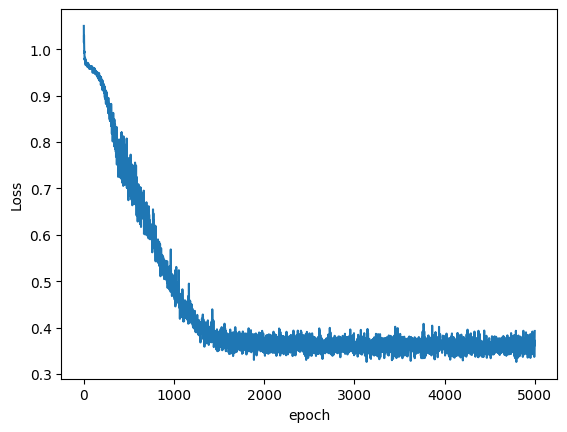

In [15]:
# Graph it out!
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

NameError: name 'n_points_plot' is not defined

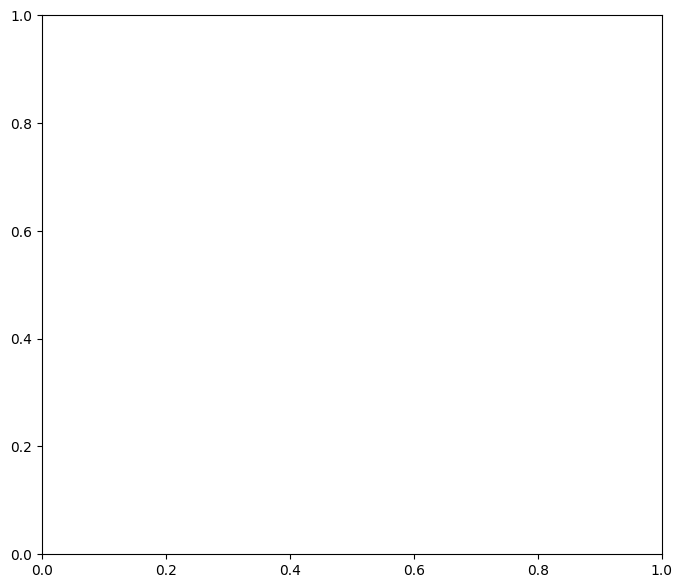

In [18]:
no_points_plot = 100
x_plot, y_plot = generate_data(no_points_plot , length)
fig, ax = plt.subplots(figsize=(8, 7))
x1_plot = np.linspace(0, length , n_points_plot)
x2_plot = np.linspace(0, length , n_points_plot)
x1_plot , x2_plot = np.meshgrid(x1_plot , x2_plot)
x1_plot = torch.tensor(x1_plot.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
x2_plot = torch.tensor(x2_plot.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
with torch.no_grad():
  u_plot = model(x_plot , y_plot).cpu().numpy().reshape(n_points_plot , n_points_plot)
  im.set_array(u_plot)
  ax.set_title(f'2D Steady State Heat Conduction')

ValueError: cannot reshape array of size 140 into shape (100,100)

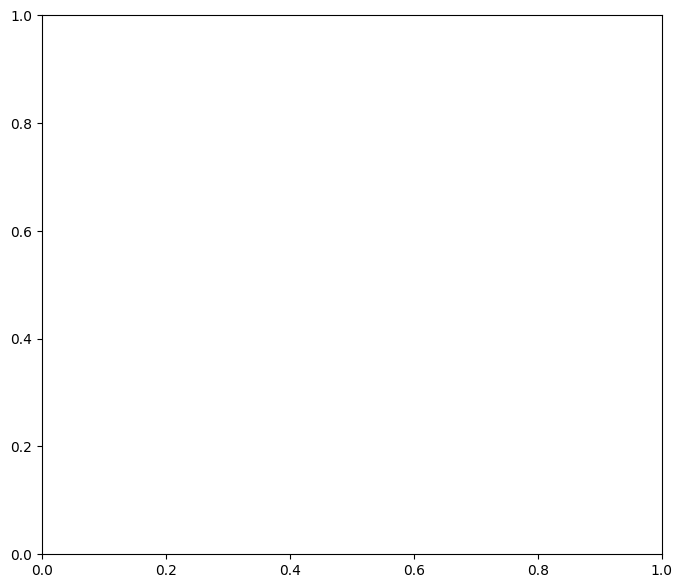

In [21]:
no_points_plot = 100
n_points_plot = 100
x_plot, y_plot = generate_data(no_points_plot , length)
fig, ax = plt.subplots(figsize=(8, 7))
x1_plot = np.linspace(0, length , n_points_plot)
x2_plot = np.linspace(0, length , n_points_plot)
x1_plot , x2_plot = np.meshgrid(x1_plot , x2_plot)
x1_plot = torch.tensor(x1_plot.flatten(), dtype=torch.float32).unsqueeze(1)
x2_plot = torch.tensor(x2_plot.flatten(), dtype=torch.float32).unsqueeze(1)
with torch.no_grad():
  u_plot = model(x_plot , y_plot).cpu().numpy().reshape(n_points_plot , n_points_plot)
  im.set_array(u_plot)
  ax.set_title(f'2D Steady State Heat Conduction')

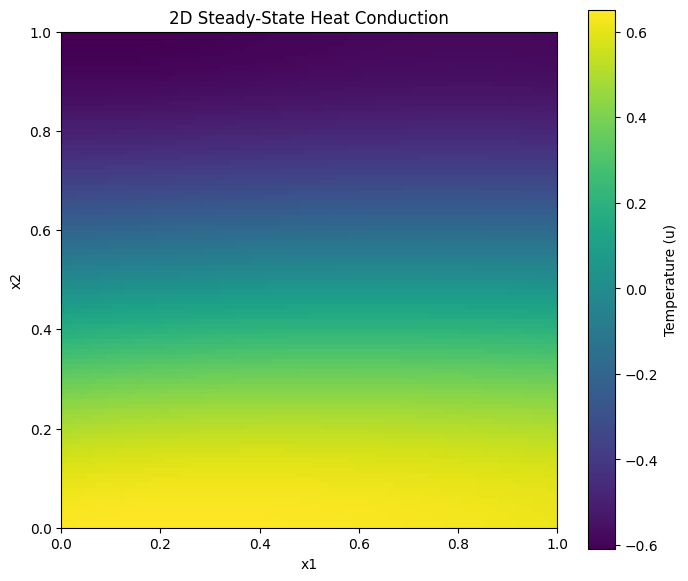

In [22]:
# Parameters
no_points_plot = 100
n_points_plot = 100
length = 1.0  # example domain size, change if needed

# Create a grid of points
x1_plot = np.linspace(0, length, n_points_plot)
x2_plot = np.linspace(0, length, n_points_plot)
x1_plot, x2_plot = np.meshgrid(x1_plot, x2_plot)

# Convert to torch tensors for model input
x1_tensor = torch.tensor(x1_plot.flatten(), dtype=torch.float32).unsqueeze(1)
x2_tensor = torch.tensor(x2_plot.flatten(), dtype=torch.float32).unsqueeze(1)

# Evaluate model on the grid
with torch.no_grad():
    u_pred = model(x1_tensor, x2_tensor).cpu().numpy().reshape(n_points_plot, n_points_plot)

# Plot the result
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(u_pred, extent=[0, length, 0, length], origin='lower', cmap='viridis')
ax.set_title('2D Steady-State Heat Conduction')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
fig.colorbar(im, ax=ax, label='Temperature (u)')
plt.show()

In [ ]:
def pde_loss(model , x, y, t, epsilon , f):
u = model(x, y, t)
u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
create_graph=True)[0]
u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
create_graph=True)[0]
u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u),
create_graph=True)[0]
u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
create_graph=True)[0]
u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y),
create_graph=True)[0]
residual = u_t - epsilon * (u_xx + u_yy) - f
return torch.mean(residual ** 2)